# Importing Libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# EDA and Data Cleaning

In [2]:
cc = pd.read_csv(r"/content/fraudTest.csv")

In [3]:
cc_1 = pd.read_csv(r"/content/fraudTrain.csv")

In [4]:
cc.head(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0


In [5]:
cc_1.head(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0


In [6]:
cc_2 = pd.concat([cc, cc_1], ignore_index=True)

In [7]:
cc_new = cc_2.drop(columns=['Unnamed: 0','cc_num','merchant','first','last','trans_num','unix_time','street','dob','zip'],axis=1)

In [8]:
cc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   category               object 
 2   amt                    float64
 3   gender                 object 
 4   city                   object 
 5   state                  object 
 6   lat                    float64
 7   long                   float64
 8   city_pop               int64  
 9   job                    object 
 10  merch_lat              float64
 11  merch_long             float64
 12  is_fraud               int64  
dtypes: float64(5), int64(2), object(6)
memory usage: 183.7+ MB


# Data Preprocessing

In [9]:
cc_new['trans_date_trans_time'] = pd.to_datetime(cc_new['trans_date_trans_time'])
cc_new['hour'] = cc_new['trans_date_trans_time'].dt.hour

In [10]:
cc_new = cc_new.drop(columns=['trans_date_trans_time'],axis=1)

# Data imbalance check

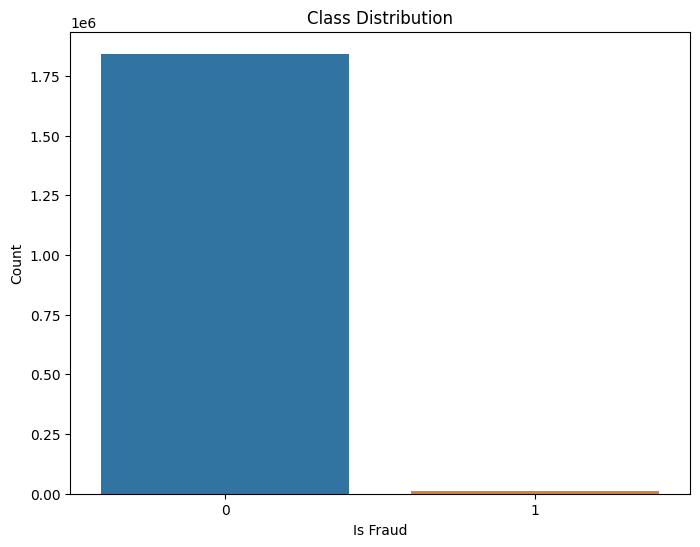

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(x='is_fraud', data=cc_new)
plt.title('Class Distribution')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

# # Data Preprocessing

In [12]:
cc_new['gender'] = cc_new['gender'].map({'M': 0, 'F': 1})

In [13]:
cc_new['is_fraud'].value_counts()

0    1842743
1       9651
Name: is_fraud, dtype: int64

In [14]:
fraud = cc_new[cc_new['is_fraud']==1]

In [15]:
non_fraud = cc_new[cc_new['is_fraud']==0]

In [16]:
non_fraud_new = non_fraud.iloc[:100000]

In [17]:
cc_new_1 = pd.concat([non_fraud_new, fraud], ignore_index=True)

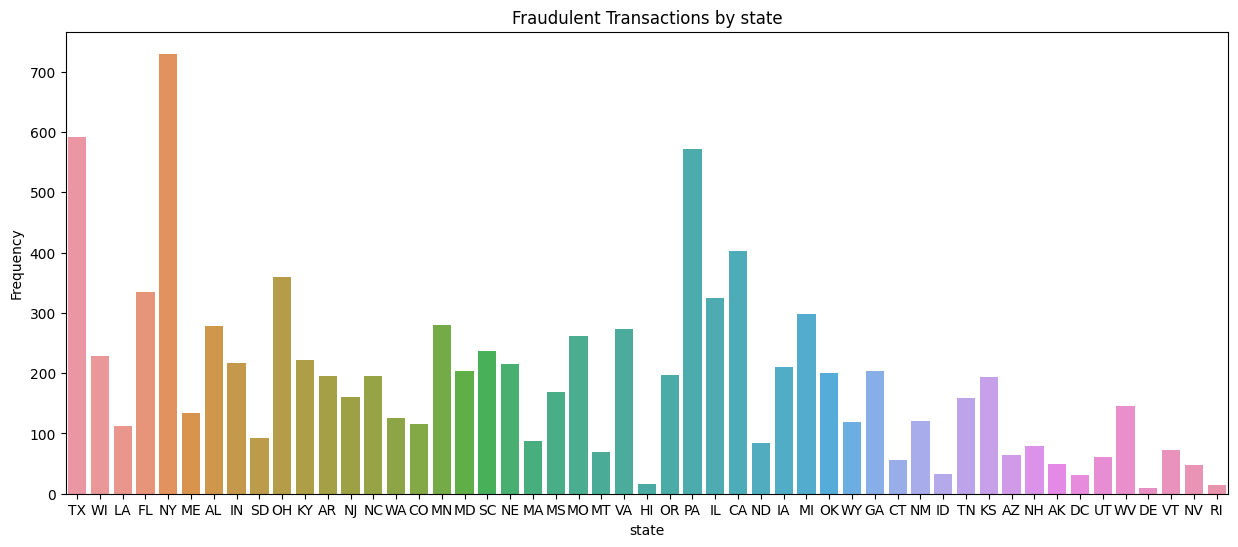

In [18]:
plt.figure(figsize=(15, 6))
sns.countplot(x='state', data=fraud)
plt.title('Fraudulent Transactions by state')
plt.xlabel('state')
plt.ylabel('Frequency')
plt.show()

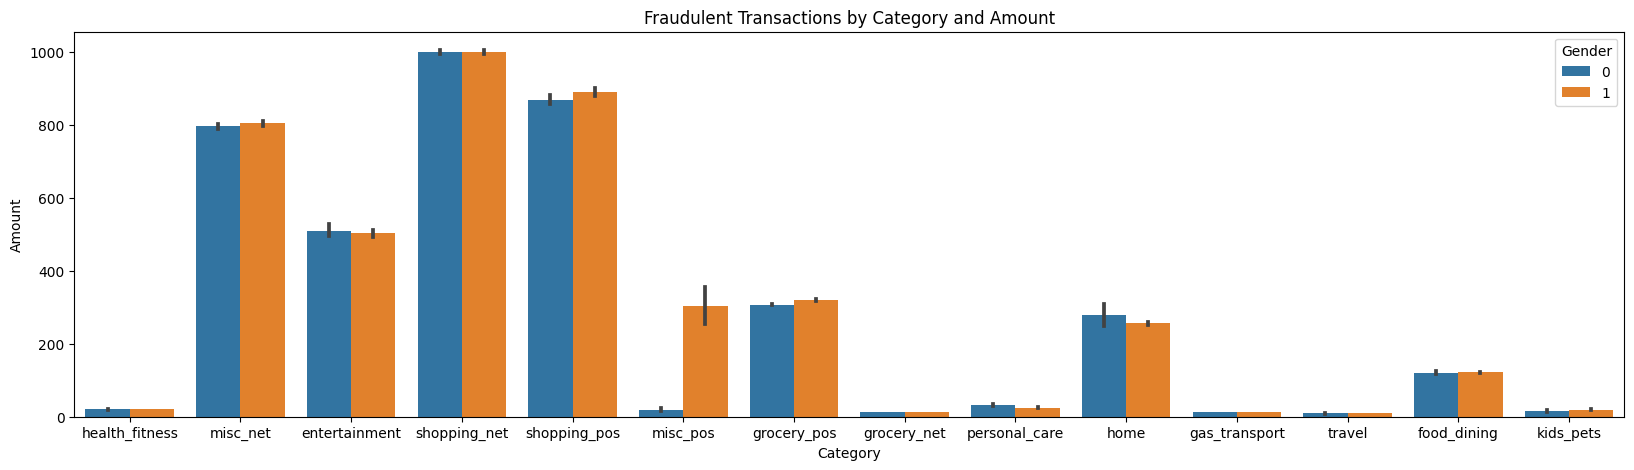

In [19]:
plt.figure(figsize=(20, 5))
sns.barplot(data=fraud, x="category", y="amt", hue="gender")
plt.title("Fraudulent Transactions by Category and Amount")
plt.xlabel("Category")
plt.ylabel("Amount")
plt.legend(title="Gender")
plt.show()

In [20]:
cc_updated = pd.get_dummies(cc_new_1, columns=['category','city','state','job'])

In [21]:
X = cc_updated.drop(columns=['is_fraud'])

In [22]:
y = cc_updated['is_fraud']

# Split Train and Test Data

In [23]:
stratified_split = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
for train_index, test_index in stratified_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Handle Data Imbalance

In [24]:
smote = SMOTE(random_state=42)

In [25]:
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

In [30]:
lg_model = LogisticRegression(random_state=42)
lg_model.fit(X_train_oversampled, y_train_oversampled)

LogisticRegression(random_state=42)

In [31]:
lg_ypred = lg_model.predict(X_test)

In [32]:
print("Accuracy score is: ",round(accuracy_score(y_test, lg_ypred)*100,2),'%')

Accuracy score is:  93.39 %


In [33]:
lgconfusion_matrix = confusion_matrix(y_test, lg_ypred)

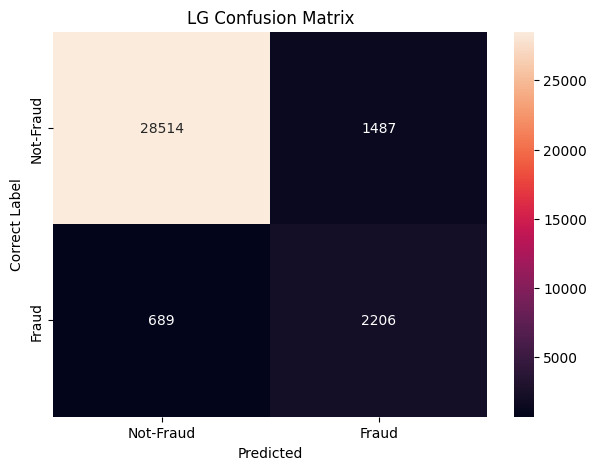

In [35]:
plt.figure(figsize=(7, 5))
plt.title('LG Confusion Matrix')
sns.heatmap(lgconfusion_matrix, annot=True, xticklabels=["Not-Fraud","Fraud"],
            yticklabels=["Not-Fraud","Fraud"], fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Correct Label')
plt.show()

In [36]:
rf_model= RandomForestClassifier()
rf_model.fit(X_train_oversampled, y_train_oversampled)

RandomForestClassifier()

In [37]:
rf_ypred = rf_model.predict(X_test)
print("Acuuracy score is: ",round(accuracy_score(y_test, rf_ypred)*100,2),'%')

Acuuracy score is:  97.77 %


In [39]:
rf_confusion_matrix = confusion_matrix(y_test, rf_ypred)

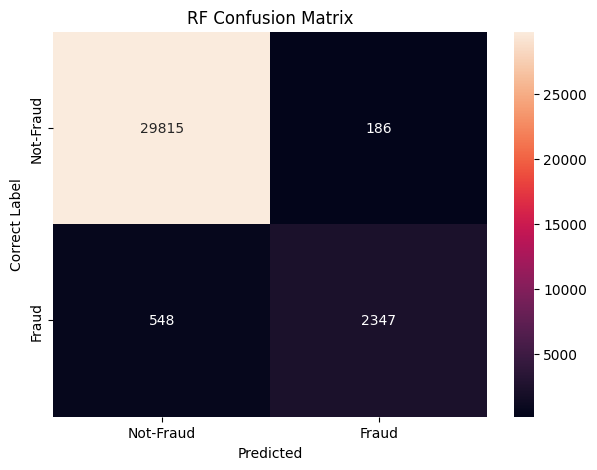

In [40]:
plt.figure(figsize=(7, 5))
plt.title('RF Confusion Matrix')
sns.heatmap(rf_confusion_matrix, annot=True, xticklabels=["Not-Fraud","Fraud"],
            yticklabels=["Not-Fraud","Fraud"], fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Correct Label')
plt.show()